In [1]:
pip install DeepXDE

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import pandas as pd
from IPython.display import display
import tensorflow as tf

x_lower = -50
x_upper = 50
t_lower = 0
t_upper = 10

α = 0.3
β = 0

α_0 = 0.3
k = 1
ω = 0.88
x_0 = -30
θ_0 = 0
μ = 4 * (k ** 2 - ω)

c = 2 * k

x = np.linspace(x_lower, x_upper, 256)
t = np.linspace(t_lower, t_upper, 201)
X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

space_domain = dde.geometry.Interval(x_lower, x_upper)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)


def pde(x, y):
    u = y[:, 0:1]
    v = y[:, 1:2]

    u_t = dde.grad.jacobian(y, x, i=0, j=1)
    v_t = dde.grad.jacobian(y, x, i=1, j=1)

    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)

    f_u = -v_t + u_xx + u * (u ** 2 + v ** 2) * (1 - α * (u ** 2 + v ** 2) + β * (u ** 2 + v ** 2) ** 2)
    f_v = u_t + v_xx + v * (u ** 2 + v ** 2) * (1 - α * (u ** 2 + v ** 2) + β * (u ** 2 + v ** 2) ** 2)

    return [f_u, f_v]


bc_u_0 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0
)
bc_u_1 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=0
)
bc_v_0 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1
)
bc_v_1 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=1
)


def init_cond_u(x):
    exp1 = np.exp(np.float128((x[:, 0:1] - x_0) * np.sqrt(μ)))
    exp2 = np.exp(np.float128(2 * (x[:, 0:1] - x_0) * np.sqrt(μ)))

    return np.cos(k * x[:, 0:1] + θ_0) * np.sqrt(μ * exp1 / (
                ((1 / 2) * exp1 + 1) * ((1 / 2) * exp1 + 1) - (α_0 * μ / 3) * exp2))


def init_cond_v(x):
    exp1 = np.exp(np.float128((x[:, 0:1] - x_0) * np.sqrt(μ)))
    exp2 = np.exp(np.float128(2 * (x[:, 0:1] - x_0) * np.sqrt(μ)))

    return np.sin(k * x[:, 0:1] + θ_0) * np.sqrt(μ * exp1 / (
                ((1 / 2) * exp1 + 1) * ((1 / 2) * exp1 + 1) - (α_0 * μ / 3) * exp2))


ic_u = dde.icbc.IC(geomtime, init_cond_u, lambda _, on_initial: on_initial, component=0)
ic_v = dde.icbc.IC(geomtime, init_cond_v, lambda _, on_initial: on_initial, component=1)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u_0, bc_u_1, bc_v_0, bc_v_1, ic_u, ic_v],
    num_domain=30000,
    num_boundary=500,
    num_initial=3000,
    train_distribution="pseudo"
)

# предобработка входа


def input_transform(input_data):
    x = input_data[:, 0:1]
    t = input_data[:, 1:2]

    return x - c * t


# преобразование выхода нейронной сети


def output_transform(input_data, output_data):
    x = input_data[:, 0:1]
    t = input_data[:, 1:2]

    u = output_data[:, 0:1] * tf.cos(k * x - ω * t)
    v = output_data[:, 1:2] * tf.sin(k * x - ω * t)

    return tf.concat([u, v], axis=1)


net = dde.nn.FNN([2] + [32] * 4 + [2], "tanh", "Glorot normal")

net.apply_feature_transform(input_transform)
net.apply_output_transform(output_transform)

model = dde.Model(data, net)

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=5e-3,
    decay_steps=100,
    decay_rate=0.019,
    staircase=False
)

opt = tf.compat.v1.train.AdamOptimizer(learning_rate=5e-3)

model.compile(optimizer=opt, lr=lr_schedule, loss="MSE")
model.train(iterations=50000, display_every=1000)

2024-04-28 12:44:44.712453: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-28 12:44:45.961321: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-28 12:44:49.207094: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term


Enable just-in-time compilation with XLA.




Compiling model...
Building feed-forward neural network...


/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.097676 s



/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.598957 s



2024-04-28 12:45:03.476309: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled


Training model...



2024-04-28 12:45:04.106969: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fa1fc0045c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-28 12:45:04.107016: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-04-28 12:45:04.409455: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-28 12:45:04.919704: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2024-04-28 12:45:08.453059: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'fusion_2', 8 bytes spill stores, 8 bytes spill loads

2024-04-28 12:45:08.643227: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [2.10e-02, 1.85e-02, 8.66e-02, 1.02e-01, 1.09e-02, 9.32e-03, 4.29e-02, 1.85e-02]    [2.10e-02, 1.85e-02, 8.66e-02, 1.02e-01, 1.09e-02, 9.32e-03, 4.29e-02, 1.85e-02]    []  
1000      [2.89e-05, 3.51e-05, 3.98e-05, 2.65e-05, 3.40e-05, 4.20e-05, 1.14e-03, 1.16e-03]    [2.89e-05, 3.51e-05, 3.98e-05, 2.65e-05, 3.40e-05, 4.20e-05, 1.14e-03, 1.16e-03]    []  
2000      [1.37e-05, 7.90e-06, 9.16e-06, 6.69e-06, 8.40e-06, 1.11e-05, 1.33e-04, 1.28e-04]    [1.37e-05, 7.90e-06, 9.16e-06, 6.69e-06, 8.40e-06, 1.11e-05, 1.33e-04, 1.28e-04]    []  
3000      [9.35e-05, 9.26e-05, 3.93e-04, 4.64e-04, 1.48e-03, 1.27e-03, 4.12e-04, 8.02e-04]    [9.35e-05, 9.26e-05, 3.93e-04, 4.64e-04, 1.48e-03, 1.27e-03, 4.12e-04, 8.02e-04]    []  
4000      [2.58e-06, 2.99e-06, 2.08e-07, 3.47e-07, 5.46e-07, 4.26e-07, 5.97e-0

(<deepxde.model.LossHistory at 0x7fa2c02a99c0>,
 <deepxde.model.TrainState at 0x7fa2c02a9930>)

In [3]:
model.compile("L-BFGS", lr=dde.optimizers.set_LBFGS_options(maxcor=50, ftol=2.220446049250313e-16, gtol=1e-08, maxiter=10000, maxfun=10000, maxls=50), loss="MSE")
model.train(iterations=10000, display_every=1000)

Compiling model...
'compile' took 1.464713 s



2024-04-28 12:58:01.655361: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1780] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).


Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
50000     [6.69e-08, 6.90e-08, 1.34e-08, 7.78e-09, 2.51e-09, 9.17e-09, 9.74e-09, 1.67e-08]    [6.69e-08, 6.90e-08, 1.34e-08, 7.78e-09, 2.51e-09, 9.17e-09, 9.74e-09, 1.67e-08]    []  


2024-04-28 12:58:11.263213: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'fusion_71', 12 bytes spill stores, 12 bytes spill loads



INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000000
  Number of iterations: 667
  Number of functions evaluations: 732
50732     [1.26e-08, 1.17e-08, 1.01e-09, 1.08e-09, 2.42e-10, 2.69e-09, 7.72e-09, 7.04e-09]    [1.26e-08, 1.17e-08, 1.01e-09, 1.08e-09, 2.42e-10, 2.69e-09, 7.72e-09, 7.04e-09]    []  

Best model at step 50732:
  train loss: 4.41e-08
  test loss: 4.41e-08
  test metric: []

'train' took 22.321375 s



(<deepxde.model.LossHistory at 0x7fa2c02a99c0>,
 <deepxde.model.TrainState at 0x7fa2c02a9930>)

x     t    pred_u  ...        true_u        true_v        true_h
0     -50.000000   0.0  0.000213  ...  6.550161e-04  1.780993e-04  6.787971e-04
1     -49.607843   0.0  0.000237  ...  6.153952e-04  4.752877e-04  7.775665e-04
2     -49.215686   0.0  0.000198  ...  4.433478e-04  7.725301e-04  8.907076e-04
3     -48.823529   0.0  0.000067  ...  1.310968e-04  1.011854e-03  1.020311e-03
4     -48.431373   0.0 -0.000177  ... -3.042098e-04  1.128489e-03  1.168773e-03
...          ...   ...       ...  ...           ...           ...           ...
51451  48.431373  10.0  0.000009  ... -8.827973e-10  2.334975e-09  2.496286e-09
51452  48.823529  10.0  0.000016  ... -1.491190e-09  1.589105e-09  2.179198e-09
51453  49.215686  10.0  0.000018  ... -1.733134e-09  7.844254e-10  1.902387e-09
51454  49.607843  10.0  0.000016  ... -1.659842e-09  5.456431e-11  1.660739e-09
51455  50.000000  10.0  0.000012  ... -1.357209e-09 -5.097659e-10  1.449785e-09

[51456 rows x 8 columns]

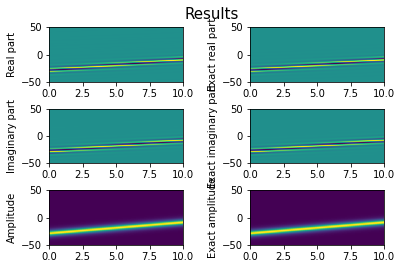

In [4]:
prediction = model.predict(X_star)
u = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v = griddata(X_star, prediction[:, 1], (X, T), method="cubic")

q = np.sqrt(u ** 2 + v ** 2)


def u_exact(x, t):
    return np.cos(k * x - ω * t + θ_0) * np.sqrt(μ * np.exp((x - 2 * k * t - x_0) * np.sqrt(μ)) / (
                ((1 / 2) * np.exp((x - 2 * k * t - x_0) * np.sqrt(μ)) + 1) ** 2 - (α_0 * μ / 3) * np.exp(
            2 * (x - 2 * k * t - x_0) * np.sqrt(μ))))


def v_exact(x, t):
    return np.sin(k * x - ω * t + θ_0) * np.sqrt(μ * np.exp((x - 2 * k * t - x_0) * np.sqrt(μ)) / (
            ((1 / 2) * np.exp((x - 2 * k * t - x_0) * np.sqrt(μ)) + 1) ** 2 - (α_0 * μ / 3) * np.exp(
        2 * (x - 2 * k * t - x_0) * np.sqrt(μ))))


def q_exact(x, t):
    return np.sqrt(μ * np.exp((x - 2 * k * t - x_0) * np.sqrt(μ)) / (
            ((1 / 2) * np.exp((x - 2 * k * t - x_0) * np.sqrt(μ)) + 1) ** 2 - (α_0 * μ / 3) * np.exp(
        2 * (x - 2 * k * t - x_0) * np.sqrt(μ))))


data_ = {'x': X.flatten(), 't': T.flatten(), 'pred_u': u.flatten(), 'pred_v': v.flatten(), 'pred_h': q.flatten(),
        'true_u': u_exact(X, T).flatten(), 'true_v': v_exact(X, T).flatten(), 'true_h': q_exact(X, T).flatten()
         }

df = pd.DataFrame(data_)
df.to_orc('my_data_pred1.orc')
display(df)

fig, ax = plt.subplots(3, 2)

plt.suptitle("Results", fontsize=15, x=0.5, y=0.95)

ax[0, 0].set_ylabel("Real part")
ax[0, 0].imshow(
    u.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[1, 0].set_ylabel("Imaginary part")
ax[1, 0].imshow(
    v.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[2, 0].set_ylabel("Amplitude")
ax[2, 0].imshow(
    q.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)

ax[0, 1].set_ylabel("Exact real part")
ax[0, 1].imshow(
    u_exact(X, T).T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[1, 1].set_ylabel("Exact imaginary part")
ax[1, 1].imshow(
    v_exact(X, T).T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[2, 1].set_ylabel("Exact amplitude")
ax[2, 1].imshow(
    q_exact(X, T).T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)

plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()